In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from preprocess import *
from torch.utils.data import Dataset, DataLoader
from blazeface import BlazeFace
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
import pickle

In [2]:
torch.cuda.is_available()

True

In [3]:
DATA_FOLDER = '../input/deepfake-detection-challenge'
TRAIN_SAMPLE_FOLDER = 'train_sample_videos'
TEST_FOLDER = 'test_videos'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

## Network class definition

In [5]:
class MyLSTM(nn.Module):
    def __init__(self, num_layers=2, num_hidden_nodes=512):
        super(MyLSTM, self).__init__()
        self.num_layers = num_layers
        self.num_hidden_nodes = num_hidden_nodes

        # input dim is 167, output 200
        self.lstm = nn.LSTM(167, num_hidden_nodes,
                            batch_first=True, num_layers=num_layers)
        # fully connected
        self.fc1 = nn.Linear(num_hidden_nodes, num_hidden_nodes)
        self.act = nn.Sigmoid()
        self.fc2 = nn.Linear(num_hidden_nodes, 2)
        self.softmax = nn.Softmax()

    def forward(self, x, hidden):
#         print(x.device, hidden[0].device)
        y, hidden = self.lstm(x, hidden)    # returns the two outputs
        y = y[:, -1, :]  # get only the last output
        y = self.fc1(y)
        y = self.fc2(y)
        y = F.softmax(y, dim=1)

        return y, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.num_layers, batch_size, self.num_hidden_nodes).zero_().to(device),
                  weight.new(self.num_layers, batch_size, self.num_hidden_nodes).zero_().to(device))
        return hidden


## Dataset class definition

In [6]:
class FourierDataset(Dataset):
    def __init__(self, data, sequence_length=24):
        """
        data: a list of (label: string, fourier_data: numpy array, name: string)

        """
        self.data = []
        for elt in data:
            label, spects, name = elt
            label = torch.tensor(0 if label == 'FAKE' else 1)

            # Moving window sequence generation without overalap
            # other ideas: 1. Random sampling, 2. Moving qindow with overlap
            # this data will be shuffled
            for i in range(0, sequence_length * (spects.shape[0] // sequence_length), sequence_length):
                spect = torch.tensor(spects[i:i+sequence_length, :])
                self.data.append((spect, label))

    def __getitem__(self, idx):
        return self.data[idx]  # spect (sequence_length, 167), label (2)

    def __len__(self):
        return len(self.data)

## Helper functions

In [7]:
def read_data():
    with open("train_data.txt", "rb") as fp:   # Unpickling
        training_data = pickle.load(fp)
    return training_data


In [8]:
training_data = read_data()

In [9]:
def train(model, training_data, loss_function, optimizer, epochs=1000, batch_size = 69):
    training_data = FourierDataset(training_data)
    trainloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, drop_last=True)

    hidden = model.init_hidden(batch_size)
    for h in hidden:
        h = h.to(device)    
    
    print_every = 12
    i = 0
    losses = []
    accs = []
    running_loss = 0.0
    running_acc = 0.0
    for epoch in range(epochs):  # again, normally you would NOT do 100 epochs, it is toy data
        for inp, labels in trainloader:  # renamed sequence to inp because inp is a batch of sequences
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            inp = inp.float().to(device)
            labels = labels.to(device)
            
            # Step 2. Run our forward pass.
            tag_scores, h = model(inp, hidden)

            # Step 3. Compute the loss, gradients, and update the parameters by
            # calling optimizer.step()
            loss = loss_function(tag_scores, labels)
            loss.backward()
            optimizer.step()

            running_acc += torch.mean((tag_scores.argmax(dim=1) == labels).float()).item()

            # print statistics
            running_loss += loss.item()
            if i % print_every == print_every-1:
                print('[%d, %5d] loss: %.3f - acc: %.3f' %
                      (epoch + 1, i + 1, running_loss / print_every, running_acc * 100 / print_every))
                
                losses.append(running_loss / print_every)
                accs.append(running_acc * 100 / print_every)
                
                running_loss = 0.0
                running_acc = 0.0
            i += 1
    return losses, accs

In [10]:
model = MyLSTM()
model.to(device)
loss_function = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

losses, accs = train(model, training_data, loss_function, optimizer, epochs=1000, batch_size=100)

[2,    12] loss: 0.675 - acc: 56.333
[3,    24] loss: 0.632 - acc: 67.667
[5,    36] loss: 0.592 - acc: 70.167
[6,    48] loss: 0.588 - acc: 69.917
[8,    60] loss: 0.551 - acc: 74.583
[9,    72] loss: 0.573 - acc: 71.167
[11,    84] loss: 0.560 - acc: 74.417
[12,    96] loss: 0.590 - acc: 67.750
[14,   108] loss: 0.562 - acc: 72.833
[15,   120] loss: 0.542 - acc: 76.750
[17,   132] loss: 0.526 - acc: 76.583
[18,   144] loss: 0.573 - acc: 71.833
[20,   156] loss: 0.576 - acc: 71.583
[21,   168] loss: 0.558 - acc: 73.000
[23,   180] loss: 0.538 - acc: 76.167
[24,   192] loss: 0.553 - acc: 74.167
[26,   204] loss: 0.549 - acc: 74.000
[27,   216] loss: 0.523 - acc: 78.083
[29,   228] loss: 0.531 - acc: 76.417
[30,   240] loss: 0.539 - acc: 75.250
[32,   252] loss: 0.514 - acc: 79.000
[33,   264] loss: 0.504 - acc: 79.583
[35,   276] loss: 0.561 - acc: 74.167
[36,   288] loss: 0.517 - acc: 78.167
[38,   300] loss: 0.542 - acc: 75.667
[39,   312] loss: 0.552 - acc: 73.500
[41,   324] loss: 

[320,  2556] loss: 0.400 - acc: 91.000
[321,  2568] loss: 0.395 - acc: 92.000
[323,  2580] loss: 0.394 - acc: 91.667
[324,  2592] loss: 0.386 - acc: 92.750
[326,  2604] loss: 0.401 - acc: 90.750
[327,  2616] loss: 0.420 - acc: 88.917
[329,  2628] loss: 0.404 - acc: 91.250
[330,  2640] loss: 0.407 - acc: 90.833
[332,  2652] loss: 0.397 - acc: 91.583
[333,  2664] loss: 0.404 - acc: 90.750
[335,  2676] loss: 0.430 - acc: 87.750
[336,  2688] loss: 0.452 - acc: 85.833
[338,  2700] loss: 0.439 - acc: 87.000
[339,  2712] loss: 0.409 - acc: 90.583
[341,  2724] loss: 0.403 - acc: 90.917
[342,  2736] loss: 0.411 - acc: 90.000
[344,  2748] loss: 0.420 - acc: 88.833
[345,  2760] loss: 0.431 - acc: 87.833
[347,  2772] loss: 0.395 - acc: 92.083
[348,  2784] loss: 0.416 - acc: 89.833
[350,  2796] loss: 0.415 - acc: 89.500
[351,  2808] loss: 0.410 - acc: 89.833
[353,  2820] loss: 0.417 - acc: 89.250
[354,  2832] loss: 0.410 - acc: 89.750
[356,  2844] loss: 0.419 - acc: 88.917
[357,  2856] loss: 0.409 

[638,  5100] loss: 0.373 - acc: 94.083
[639,  5112] loss: 0.362 - acc: 95.083
[641,  5124] loss: 0.387 - acc: 92.250
[642,  5136] loss: 0.384 - acc: 92.583
[644,  5148] loss: 0.360 - acc: 95.250
[645,  5160] loss: 0.354 - acc: 95.917
[647,  5172] loss: 0.376 - acc: 93.500
[648,  5184] loss: 0.367 - acc: 94.750
[650,  5196] loss: 0.375 - acc: 93.667
[651,  5208] loss: 0.412 - acc: 89.417
[653,  5220] loss: 0.393 - acc: 91.917
[654,  5232] loss: 0.381 - acc: 93.250
[656,  5244] loss: 0.373 - acc: 94.000
[657,  5256] loss: 0.374 - acc: 94.000
[659,  5268] loss: 0.370 - acc: 94.083
[660,  5280] loss: 0.369 - acc: 94.417
[662,  5292] loss: 0.371 - acc: 94.000
[663,  5304] loss: 0.378 - acc: 93.333
[665,  5316] loss: 0.375 - acc: 93.917
[666,  5328] loss: 0.379 - acc: 93.667
[668,  5340] loss: 0.384 - acc: 92.833
[669,  5352] loss: 0.402 - acc: 90.583
[671,  5364] loss: 0.456 - acc: 84.917
[672,  5376] loss: 0.431 - acc: 87.833
[674,  5388] loss: 0.403 - acc: 90.667
[675,  5400] loss: 0.368 

[956,  7644] loss: 0.343 - acc: 97.000
[957,  7656] loss: 0.340 - acc: 97.333
[959,  7668] loss: 0.344 - acc: 96.833
[960,  7680] loss: 0.345 - acc: 97.000
[962,  7692] loss: 0.343 - acc: 97.000
[963,  7704] loss: 0.347 - acc: 96.583
[965,  7716] loss: 0.352 - acc: 96.333
[966,  7728] loss: 0.344 - acc: 96.917
[968,  7740] loss: 0.343 - acc: 97.083
[969,  7752] loss: 0.346 - acc: 96.750
[971,  7764] loss: 0.346 - acc: 96.750
[972,  7776] loss: 0.342 - acc: 97.167
[974,  7788] loss: 0.342 - acc: 97.167
[975,  7800] loss: 0.342 - acc: 97.167
[977,  7812] loss: 0.338 - acc: 97.500
[978,  7824] loss: 0.342 - acc: 97.083
[980,  7836] loss: 0.337 - acc: 97.667
[981,  7848] loss: 0.341 - acc: 97.250
[983,  7860] loss: 0.337 - acc: 97.583
[984,  7872] loss: 0.341 - acc: 97.250
[986,  7884] loss: 0.337 - acc: 97.667
[987,  7896] loss: 0.342 - acc: 97.083
[989,  7908] loss: 0.340 - acc: 97.333
[990,  7920] loss: 0.341 - acc: 97.250
[992,  7932] loss: 0.338 - acc: 97.500
[993,  7944] loss: 0.340 

In [11]:
from scipy.signal import resample

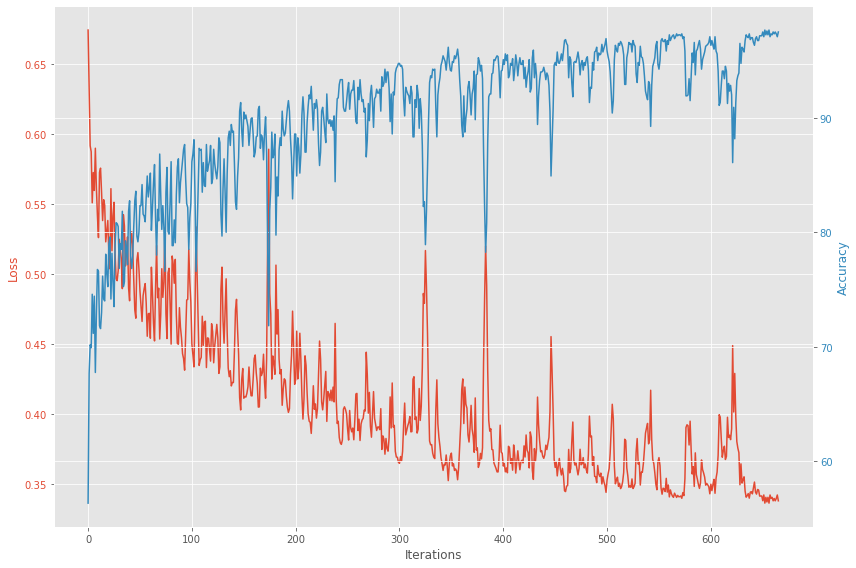

In [12]:
plt.style.use('ggplot')

fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'C0'
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss', color=color)
ax1.plot(losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'C1'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(accs, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
